# Advanced Exercises - solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.wcs import WCS
from astroquery.vizier import Vizier

from astropy.table import Table
from astropy.units import Quantity
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from astropy import units as u

from photutils.aperture import CircularAperture
from photutils.aperture import CircularAnnulus
from photutils.aperture import aperture_photometry

from astropy.visualization import (imshow_norm, 
                                   ZScaleInterval,
                                   SquaredStretch,
                                   LinearStretch,
                                  LogStretch,
                                   SqrtStretch,
                                  MinMaxInterval,
                                  ImageNormalize)

from astropy.convolution import AiryDisk2DKernel

from photutils import centroid_com, centroid_1dg, centroid_2dg

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.


# Astropy photometry examples

### First let's explore some of the documentation for astropy's photometry functions. I'll leave you with a few examples but it will be your job to figure out how to get to the end!

Let's start by adding a point source to a field of Poisson noise.

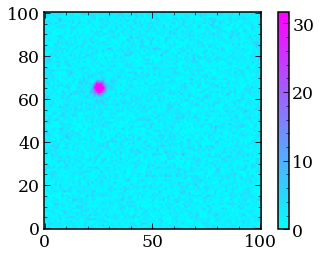

In [19]:
source = np.array(AiryDisk2DKernel(5,x_size=31,y_size=31)) # 2D gaussian star
source = source/np.sum(source)*1000.0  # Normalize the total flux of the source to 1000

image = np.zeros([101,101])
image[50:81,10:41] = source  #y,x, note y starts from top

image += 2.0 # Add sky background of 2 e-
image = np.random.poisson(image)  # Sample the image with Poisson noise
image = image + np.random.normal(0.0,1.0,[101,101])  # Add a read noise of 1 e-

plt.imshow(image,vmin=0,vmax=0.5*np.max(image), origin='lower')
plt.colorbar()

Next we will find the intensity-weighted centroid of this image using astropy photutils. This is easy since there's only one source in the field.

In [20]:
x, y = centroid_1dg(image)
print(x, y)

25.20581403501923 64.6610178279533


Using DAOStarFinder is useful when there are multiple sources in the image. Let's add another one. 

https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html

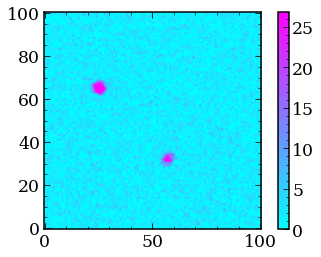

In [21]:
image2 = np.zeros([101,101])
image2[50:81,10:41] = source  #y,x, note y starts from top

source2 = np.array(AiryDisk2DKernel(5,x_size=25,y_size=25))
source2 = source2/np.sum(source2) * 500
image2[20:45,45:70] = source2

image2 += 2.0 # Add sky background of 2 e-
image2 = np.random.poisson(image2)  # Sample the image with Poisson noise
image2 = image2 + np.random.normal(0.0,1.0,[101,101])  # Add a read noise of 1 e-

plt.imshow(image2,vmin=0,vmax=0.5*np.max(image2), origin='lower')
plt.colorbar()
plt.show()

We again define the background with sigma clipped stats, then run the detection algorithm.

In [22]:
mean, median, std = sigma_clipped_stats(image2, sigma=3.0)
print(mean, median, std)

1.9820633516011412 1.8777298772786057 1.6918017422281482


In [23]:
daofind = DAOStarFinder(fwhm=5.0, threshold=5.*std)  
source_find = daofind(image2-median)

source_find


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,56.881611661854436,32.01150126877641,0.49802348093271065,0.5175838923366366,0.006086685786140289,49,0.0,26.373413018467183,4.483488251658729,-1.6290400902243176
2,25.04303486839476,64.72584268608902,0.3212868292065652,-0.22928190203058046,0.05797283127688295,49,0.0,39.38085034167286,7.947422341390095,-2.2505657321966472


Next we will perform aperture photometry. The first step is to define an aperture in which we will measure flux. Then we have to characterize the background flux in an annulus that does not touch the source. The background flux per pixel is the measured background divided by the area of the annulus, which we will subtract from the aperture sum to get the background-subtracted flux.

https://photutils.readthedocs.io/en/stable/aperture.html

Note that DAOStarFinder reports a flux *density* in the flux column of the table which is a function of area and the defined threshold. It's more useful to work in total fluxes when measuring colors, which we can do directly with photutil's aperture photometry.

In [26]:
# For our single source

positions = (x, y) # Set the centroid of our source using the most accurate value from above
apertures = CircularAperture(positions, r=5.)  # Use an aperture with r=5 pixels (~FWHM)

# Now define an annulus - r_in and r_out set position of annulus
annulus_apertures = CircularAnnulus(positions, r_in=8., r_out=10.)

# We can combine the apertures into a tuple. Aperture_sum_0 is science, aperture_sum_1 is bg
apers=[apertures,annulus_apertures]  
phot_table = aperture_photometry(image, apers)
print(phot_table)

# Now calculate background per pixel
bkg_mean = phot_table['aperture_sum_1'][0] / annulus_apertures.area
bkg_sum = bkg_mean * apertures.area
print(bkg_sum)

# Now we have our background subtracted flux!
final_sum = phot_table['aperture_sum_0'][0] - bkg_sum
print(final_sum)

# We are missing an aperture correction to get from the aperture flux to infinite flux,
# but don't worry about that right now :) 

 id      xcenter          ycenter        aperture_sum_0     aperture_sum_1  
           pix              pix                                             
--- ----------------- ---------------- ------------------ ------------------
  1 25.20581403501923 64.6610178279533 1069.8737163687622 251.25396887996675
174.48192283331028
895.3917935354519


 id      xcenter            ycenter        aperture_sum_0     aperture_sum_1  
           pix                pix                                             
--- ------------------ ----------------- ------------------ ------------------
  1 56.881611661854436 32.01150126877641  625.7241334183515  233.0934222850047
  2  25.04303486839476 64.72584268608902 1051.7892994165002 219.87810988593105
463.8537012759871 899.0961675512702


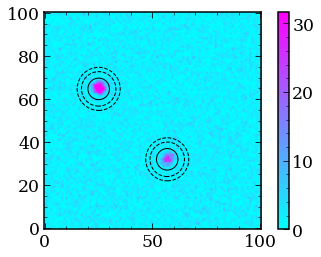

In [29]:
# For an array of sources

positions2 = np.array([source_find['xcentroid'], source_find['ycentroid']]).T # Set the centroid of our source using the most accurate value from above
apertures2 = CircularAperture(positions2, r=5.)  # Use an aperture with r=5 pixels (~FWHM)

# Now define an annulus - r_in and r_out set position of annulus
annulus_apertures2 = CircularAnnulus(positions2, r_in=8., r_out=10.)

# We can combine the apertures into a tuple. Aperture_sum_0 is science, aperture_sum_1 is bg
apers2=[apertures2,annulus_apertures2]  
phot_table2 = aperture_photometry(image2, apers2)
print(phot_table2)

# Now calculate background per pixel
bkg_mean2 = phot_table2['aperture_sum_1'] / annulus_apertures2.area
bkg_sum2 = bkg_mean2 * apertures2.area

# Now we have our background subtracted flux!
final_sum_source1 = phot_table2['aperture_sum_0'][0] - bkg_sum2[0]
final_sum_source2 = phot_table2['aperture_sum_0'][1] - bkg_sum2[1]

print(final_sum_source1, final_sum_source2)

plt.imshow(image2,vmin=0,vmax=0.5*np.max(image), origin='lower')
apertures2.plot(color='black')
annulus_apertures2.plot(color='black', linestyle='--')
plt.colorbar()
plt.show()


Then we search for sources above a 5-sigma detection threshold and subtract the background.

# Exercise 1: Producing a color-magnitude diagram of an open star cluster 

by Jackie Champagne (thank you to Erica Sawczynec for your help!)

Let's take a look at an open star cluster with B and V filter images taken at the Las Cumbres Observatory. This is NGC 2509, in the Puppis constellation.

## Goals: 
- Practice reading in FITS files
- Perform object detection algorithm to find stars
- Measure photometry
- Calculate colors and produce a color-magnitude diagram
- Bonus: learn how to manually zeropoint data

To perform photometry, we want to use a source-finding algorithm which detects circular objects with a certain significance threshold. To do this, we will need to calculate the statistics of the image to characterize the background.

### 1. Open the fits files here. You have B, V, and R images of NGC 2509.

#### Hints: 1) Recall how to access different attributes of the HDU object. 2) If you aren't sure what the files are all called, you can try using glob to find all FITS files in a directory:

from glob import glob

fitslist = glob('*.fits')

print(fitslist)

In [31]:
# open files here

B = fits.open('ngc2509_B.fits.fz')[1]
Bdata = B.data

V = fits.open('ngc2509_V.fits.fz')[1]
Vdata = V.data


### 2. Measure the mean, median, and standard deviation of the images, clipped at 3 sigma. Use sigma_clipped_stats from astropy.

Sigma clipping helps to throw out the tails of a Gaussian distribution, since real sources will be far brighter than 3sigma.

#### Hint: SIGMA_CLIPPED_STATS outputs a tuple containing the mean, median, and std, so you can define the output as three variables here, i.e.: mean, median, std = sigma_clipped_stats(arguments here)

In [32]:
mean_B, median_B, std_B = sigma_clipped_stats(Bdata, sigma=3.0)
mean_V, median_V, std_V = sigma_clipped_stats(Vdata, sigma=3.0)

### 3. Use the DAOStarFinder to detect stars in both images with a FWHM of 5 pixels at a threshold of 5sigma. 

In [53]:
daofind_B = DAOStarFinder(fwhm=6.0, threshold=5.*std_B)  
stars_B = daofind_B(Bdata - median_B)
stars_B

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,2412.209247957504,27.852626860452297,0.8902637831242343,0.2131135871337632,0.2070074600995733,49,0.0,37.536773681640625,1.002181642451385,-0.002366108131781431
2,1545.8449961837218,28.383764309109676,0.733558383279916,0.2110693779204142,-0.8535701391661856,49,0.0,39.83583068847656,1.2569617927549024,-0.2483051921307662
3,2106.0612581835294,29.20373629341784,0.9118066755987485,0.5558363069738508,0.8968809091295035,49,0.0,36.527244567871094,1.041368416663706,-0.044011004895487676
4,52.58433723397156,28.27779305185139,0.36688009064914096,-0.3928190098149255,-0.28813362900226763,49,0.0,21.078168869018555,1.3445791701474397,-0.32146594749887286
5,159.73392504526475,29.351769091059506,0.651589788023927,-0.262078053648962,0.088754569296171,49,0.0,36.840576171875,1.3793385067652966,-0.3491771512618552
6,169.4249797649649,28.50091607728193,0.4116077334002307,-0.1829399190385034,0.48707777123438056,49,0.0,26.739717483520508,1.2923789205269953,-0.2784746645016935
...,...,...,...,...,...,...,...,...,...,...
5042,643.0990102842193,4071.3066520778775,0.3063234479588512,-0.37897730304146116,-0.9722735736191244,49,0.0,6.575857162475586,1.16239496836886,-0.1633843034348908
5043,999.960432989949,4070.0709781272167,0.8101343711276056,0.3771100454453938,0.23522731159292853,49,0.0,23.488569259643555,1.0545437723235527,-0.057661528192640414


In [54]:
daofind_V = DAOStarFinder(fwhm=5.0, threshold=5.*std_V)  
stars_V = daofind_V(Vdata - median_V)
stars_V

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
1,1985.5246174289944,26.94207192016905,0.4400466756878236,-0.17486519409277876,-0.7512611972925534,49,0.0,15.40414047241211,1.0128066323902067,-0.013816341677861475
2,2308.382796817273,26.54743424975192,0.6040788399512782,-0.3888369164468913,-0.5734946014884507,49,0.0,28.188045501708984,1.3373572924673633,-0.31561862551713304
3,276.0429835375313,27.796375904015576,0.3863700954149127,0.2629089345096198,-0.3794846606933653,49,0.0,66.65130615234375,2.180841084868878,-0.8465600506053601
4,756.1567262304645,27.700593778998947,0.7680254685211956,-0.5137263818512694,-0.6337006163388195,49,0.0,74.10595703125,2.054679531111991,-0.7818602361835978
5,1828.7008369398368,28.075390629001816,0.643335619226429,0.46855301243549036,-0.2447220244463335,49,0.0,27.054611206054688,1.0932121362972371,-0.09676111092162772
6,1897.1250640565677,26.838685264430996,0.500068929989662,-0.06803115328469742,-0.7020425639573088,49,0.0,43.46766662597656,1.581182025432412,-0.4974546718109528
...,...,...,...,...,...,...,...,...,...,...
3792,1329.8702761790742,4071.9251199297555,0.5909901033670757,-0.1408199873717002,0.11075612144037668,49,0.0,35.09362030029297,1.4622075489231654,-0.41252255425400053
3793,1349.6317246831884,4070.477615254211,0.41448928433737336,-0.5276059544197504,0.5759178054258669,49,0.0,15.228229522705078,1.3375015708328197,-0.3157357518801277


### 4. Use the positions (xcentroid, ycentroid) from your daofind outputs and perform aperture photometry using astropy photutils. Display the images and plot the apertures on top. Finally, convert your fluxes to magnitudes using

$$ m = -2.5 * log_{10}F $$

 ...]

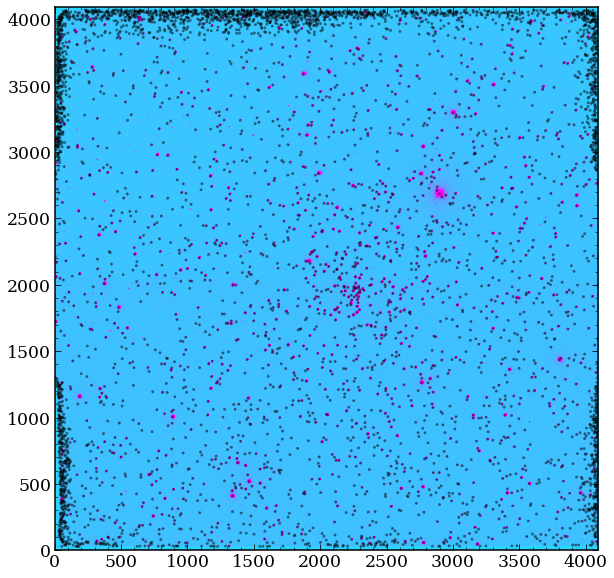

In [55]:
# A helpful function to display a color image nicely

def show_fits(ax, hdu, interval=ZScaleInterval(), stretch=LinearStretch(), cmap='gray'):
    im, norm = imshow_norm(hdu.data, ax,
                           interval=interval,
                           stretch=stretch,
                           cmap=cmap,
                        origin='lower')
    ax.set_xlabel('X coord')
    ax.set_ylabel('Y coord')
    return ax, im


positions_B = np.transpose((stars_B['xcentroid'], stars_B['ycentroid']))
apertures_B = CircularAperture(positions_B, r=5.)
annuli_B = CircularAnnulus(positions_B, r_in=8., r_out=10.)
apers_B = [apertures_B, annuli_B]

fig, ax = plt.subplots(1, 1, figsize = (10,10))
ims, norma = imshow_norm(Bdata, ax, origin='lower',  interval=ZScaleInterval(), 
                                             cmap='cool', 
                                           stretch=SquaredStretch())#, interpolation='gaussian')
apertures_B.plot(color='black', lw=1.5, alpha=0.5)



 ...]

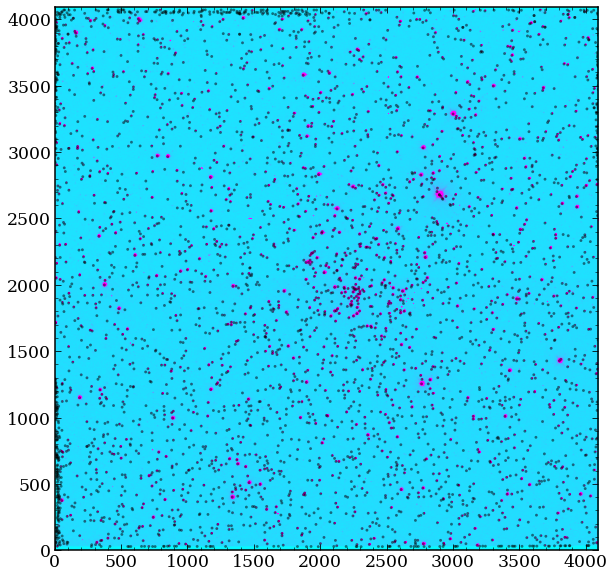

In [56]:

positions_V = np.transpose((stars_V['xcentroid'], stars_V['ycentroid']))
apertures_V = CircularAperture(positions_V, r=5.)
annuli_V = CircularAnnulus(positions_V, r_in=8., r_out=10.)
apers_V = [apertures_V, annuli_V]

fig, ax = plt.subplots(1, 1, figsize = (10,10))
ims, norma = imshow_norm(Vdata, ax, origin='lower',  interval=ZScaleInterval(), 
                                             cmap='cool', 
                                           stretch=SquaredStretch())#, interpolation='gaussian')
apertures_V.plot(color='black', lw=1.5, alpha=0.5)


In [76]:
B_phot = aperture_photometry(Bdata, apers_B)
B_bkg = B_phot['aperture_sum_1'] / annuli_B.area
B_sum = B_phot['aperture_sum_0'] - (B_bkg * apertures_B.area)
B_mag = -2.5 * np.log10(B_sum)

V_phot = aperture_photometry(Vdata, apers_V)
V_bkg = V_phot['aperture_sum_1'] / annuli_V.area
V_sum = V_phot['aperture_sum_0'] - (V_bkg * apertures_V.area)
V_mag = -2.5 * np.log10(V_sum)

/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


### 5. Before we create a CMD we need to make sure we are measuring photometry for the same stars in each image. 

Using astropy.wcs, grab the WCS information from the headers. https://docs.astropy.org/en/stable/wcs/wcsapi.html#basic-usage
There is a function that allows you to convert x, y positions to world coordinates. Do that!

Then, create a SkyCoord object from your B and V catalogs. You can learn more about that here: https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html

Finally, use match_to_catalog_sky to match it to the V catalog. Make sure to match it within 0.5 arcseconds so we know it's the same source. You can learn more about that here: https://docs.astropy.org/en/stable/coordinates/matchsep.html#matching-catalogs


In [77]:
# First access the WCS information from the header using WCS() from astropy.wcs... make sense?
WCS_ngc2509_B = WCS(B.header)
WCS_ngc2509_V = WCS(V.header)

# Then convert the x and y positions of the stars to RA and Dec. Which function should you use?
star_posB = WCS_ngc2509_B.pixel_to_world(stars_B['xcentroid'], stars_B['ycentroid'])
star_posV = WCS_ngc2509_V.pixel_to_world(stars_V['xcentroid'], stars_V['ycentroid'])
print(len(star_pos))

v_to_b_match, vbsep, _ = star_posB.match_to_catalog_sky(star_posV)
max_sep = vbsep.arcsec < 0.5
v_matches = V_mag[v_to_b_match[max_sep]]
b_matches = B_mag[max_sep]

print(len(v_matches), len(b_matches))


5048
2381 2381


Set OBSGEO-B to   -30.167447 from OBSGEO-[XYZ].
Set OBSGEO-H to     2197.994 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


-9.420853761313314
-8.760533111181676
-13.401921016618239
-9.114059151290482
nan
-9.052737920302421
-11.610756037767516
-10.832829166948553
-9.554434055133417
...
-8.394030847764565


### 6. Plot your CMD! On the y axis, a CMD has magnitudes, like B, and the x axis has a color, which is the difference between two magnitudes, like B-V. 

(-0.2, 1.8)

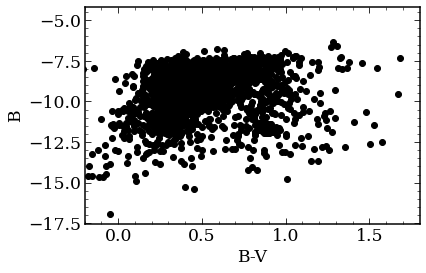

In [81]:
# your CMD here

BminusV = b_matches - v_matches

plt.plot(BminusV, b_matches, 'o')
plt.xlabel("B-V")
plt.ylabel("B")
plt.xlim(-0.2, 1.8)

## This doesn't have a lot of physical significance, because the images are not physically calibrated: the magnitudes are instrumental rather than absolute. Physical calibration involves finding the *zeropoint* of an image, which relates instrumental magnitudes from one instrument to accepted standard magnitudes. 

## To do this, we normally query a catalog to find calibrated magnitudes taken with the same filter on a different telescope. The US Naval Observatory catalog has B and V magnitudes that we can calibrate to. First, let's use the sky positions of the stars you found in your LCO images using the WCS (world coordinate system) information. Matching to a known catalog also helps confirm that your sources are real and not noise spikes.


### 7. Using Vizier, query the USNO database in a 5 arcmin region around your stars; you will need the WCS information as you used above.

### 8. Match your star catalog to the USNO results using astropy SkyCoord's match_to_catalog_sky like you did before.

Documentation you will need:

astroquery: https://astroquery.readthedocs.io/en/latest/vizier/vizier.html


In [102]:
# Collect all known stars in the USNO observatory within 5 arcmin
v = Vizier()
results = v.query_region(star_posB[0], radius='10min', catalog='USNO')
print(results[0].keys())

usno_pos = SkyCoord(ra=results[0]['RAJ2000'], dec=results[0]['DEJ2000'], unit='deg')

# And match your catalog to 0.2 arcsec precision using match_to_catalog_sky

usno_matches, usno_separation, _ = star_pos.match_to_catalog_sky(usno_pos)
match_condition = usno_separation.arcsec < 1

print(usno_separation.arcsec)
usno_bmag = results[0][usno_matches[match_condition]]['Bmag']
bmag_matches = B_mag[match_condition]
                       

['USNO-A2.0', 'RAJ2000', 'DEJ2000', 'ACTflag', 'Mflag', 'Bmag', 'Rmag', 'Epoch']
[ 550.6382602   213.4033104   431.46965034 ... 1354.51754792 1364.84949619
 1368.9710519 ]


### Finally, plot your measured B magnitudes against the USNO B magnitudes. The median of the difference in magnitudes is the scalar offset to be added to all of your measured B mags. The last step is to plot your calibrated CMD!

/Users/jcb5334/opt/miniconda3/envs/astroconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


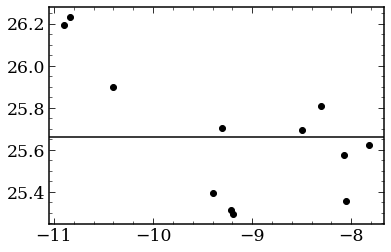

In [95]:
# Your zeropoint plot here

plt.plot(bmag_matches, usno_bmag - bmag_matches, 'o')

plt.axhline(np.median(usno_bmag-bmag_matches))

zpt_B = np.median(usno_bmag-bmag_matches)

Text(0, 0.5, 'B')

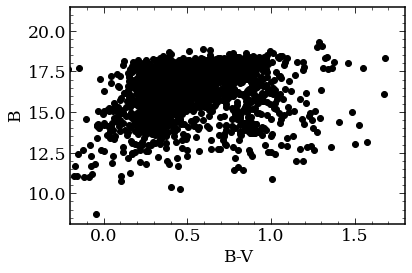

In [104]:
# Your CMD here

plt.plot(BminusV, b_matches + zpt_B, 'o')
plt.xlim(-0.2, 1.8)
plt.xlabel("B-V")
plt.ylabel("B")

# CHALLENGE EXERCISE!

## Say we didn't have a similar filter to zeropoint our images. Let's brainstorm some ideas for how we might calibrate our images!


### Goals: Query an optical database to find physically-calibrated magnitudes for these stars. Using your photometric models from Photometry1, how would you figure out the correct B and V magnitudes using colors from another library?

(answer: gaia)

In [103]:
gaia_query = Gaia.query_object_async(coordinate=star_posB[0], radius=1*u.arcmin)

reduced_query = gaia_query['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']

reduced_query


INFO: Query finished. [astroquery.utils.tap.core]


ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
deg,deg,mag,mag,mag
float64,float64,float32,float32,float32
120.21644361084195,-18.84582149486005,18.835596,19.270052,18.180105
120.21908331143091,-18.84260609597873,17.736984,18.613651,16.780748
120.22018009258127,-18.84171047449029,17.283102,17.987226,16.466385
120.21675071610375,-18.851032751292387,19.546133,19.80138,18.78537
120.21358815917628,-18.848823885728706,13.55094,13.971896,12.980186
120.2221762772308,-18.84113695884389,18.638744,19.08449,17.826366
...,...,...,...,...
120.21159847706643,-18.860442287413733,17.79536,18.257496,17.173721


In [ ]:
gaia_coords = SkyCoord(reduced_query['ra'])
gaia_match, gaia_sep, _ = star_pos.match_to_catalog_sky(ga)